In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Clean_CSV

In [57]:
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

In [35]:
%reload_ext autoreload
%aimport Clean_CSV

cases_list = ['b03','b06','b09','bi001','bi01','bi1','da001','da01','da1']

cases_listmulti = ['b06pm','b09pm','bi001pm','bi01pm','da01pm']


# Loading, Cleaning Volume-Gamma-Nd dataframes

In [36]:
## Volume-Gamma data for 3-drop cases

csv_file = ['RawData/' + elem + '_GVol.csv' for elem in cases_list]
csv_names = [elem + '_csv' for elem in cases_list]

for csv, name in zip(csv_file,csv_names):
    exec(f"{name} = pd.read_csv('{csv}')")
    print('dataframe loaded:' + f"'{name}'")

dataframe loaded:'b03_csv'
dataframe loaded:'b06_csv'
dataframe loaded:'b09_csv'
dataframe loaded:'bi001_csv'
dataframe loaded:'bi01_csv'
dataframe loaded:'bi1_csv'
dataframe loaded:'da001_csv'
dataframe loaded:'da01_csv'
dataframe loaded:'da1_csv'


In [37]:
## Volume-Gamma data for multi-drop cases

csv_filemulti = ['RawData/' + elem + '_GVol.csv' for elem in cases_listmulti]
csv_names_multi = [elem + '_csv' for elem in cases_listmulti]

for csv, name in zip(csv_filemulti,csv_names_multi):
    exec(f"{name} = pd.read_csv('{csv}')")
    print('dataframe loaded:' + f"'{name}'")


dataframe loaded:'b06pm_csv'
dataframe loaded:'b09pm_csv'
dataframe loaded:'bi001pm_csv'
dataframe loaded:'bi01pm_csv'
dataframe loaded:'da01pm_csv'


In [38]:
## Dataframe cleanup

df_namescl = ['df_' + elem for elem in cases_list]

df_namescl_multi = ['df_' + elem for elem in cases_listmulti]

for dfname,csvname in zip(df_namescl,csv_names):
    exec(f"{dfname} = Clean_CSV.clean_csv({csvname},list({csvname}.columns.values)[1:3])")
    print('dataframe cleaned:' + f"'{dfname}'")
    
for dfname,csvname in zip(df_namescl_multi,csv_names_multi):
    exec(f"{dfname} = Clean_CSV.clean_csv({csvname},list({csvname}.columns.values)[1:3])")
    print('dataframe cleaned:' + f"'{dfname}'")



dataframe cleaned:'df_b03'
dataframe cleaned:'df_b06'
dataframe cleaned:'df_b09'
dataframe cleaned:'df_bi001'
dataframe cleaned:'df_bi01'
dataframe cleaned:'df_bi1'
dataframe cleaned:'df_da001'
dataframe cleaned:'df_da01'
dataframe cleaned:'df_da1'
dataframe cleaned:'df_b06pm'
dataframe cleaned:'df_b09pm'
dataframe cleaned:'df_bi001pm'
dataframe cleaned:'df_bi01pm'
dataframe cleaned:'df_da01pm'


In [39]:
## Number of drops data for 3-drop

Nd_names = ['Nd_' + elem for elem in csv_names]
Nd_csv_file = ['RawData/Nd/' + elem + '_dnum_corr.csv' for elem in cases_list]


for Nd,csv in zip(Nd_names,Nd_csv_file):
    df = pd.read_csv(csv)
    label_list = list(df.columns.values)
    df.rename(columns={label_list[0]: 'Ndrops'}, inplace=True)
    df['Time'] = df.apply(lambda row: row.name*0.005,axis=1)
    df = df[['Time','Ndrops']]
    exec(f"{Nd} = df")
    print('file loaded:' + f"'{Nd}'")


file loaded:'Nd_b03_csv'
file loaded:'Nd_b06_csv'
file loaded:'Nd_b09_csv'
file loaded:'Nd_bi001_csv'
file loaded:'Nd_bi01_csv'
file loaded:'Nd_bi1_csv'
file loaded:'Nd_da001_csv'
file loaded:'Nd_da01_csv'
file loaded:'Nd_da1_csv'


In [40]:
## Number of drops data for multi-drop

Nd_names_multi = ['Nd_' + elem for elem in csv_names_multi]
Nd_csv_file_multi = ['RawData/Nd/' + elem + '_dnum_corr.csv' for elem in cases_listmulti]


for Nd,csv in zip(Nd_names_multi,Nd_csv_file_multi):
    df = pd.read_csv(csv)
    label_list = list(df.columns.values)
    df.rename(columns={label_list[0]: 'Ndrops'}, inplace=True)
    df['Time'] = df.apply(lambda row: row.name*0.005,axis=1)
    df = df[['Time','Ndrops']]
    exec(f"{Nd} = df")
    print('file loaded:' + f"'{Nd}'")


file loaded:'Nd_b06pm_csv'
file loaded:'Nd_b09pm_csv'
file loaded:'Nd_bi001pm_csv'
file loaded:'Nd_bi01pm_csv'
file loaded:'Nd_da01pm_csv'


In [41]:
Nd_b03_csv

,Time,Ndrops
0,0.000,3
1,0.005,3
2,0.010,3
3,0.015,3
4,0.020,3
...,...,...
115,0.575,354
116,0.580,362
117,0.585,361
118,0.590,367


# RNN-LSTM with PyTorch
## Training and testing number of drops for a single case

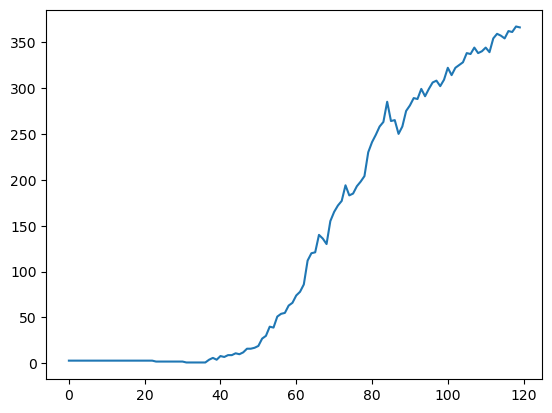

In [42]:
timeseries = Nd_b03_csv[['Ndrops']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [49]:
# OPTIONAL detrending and normalizing the linear trend
from sklearn.linear_model import LinearRegression
X = np.arange(len(timeseries)).reshape(-1, 1)
y = timeseries.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)

detrended = y - trend

min_val = np.min(detrended)
max_val = np.max(detrended)

normalized = (detrended - min_val) / (max_val - min_val)

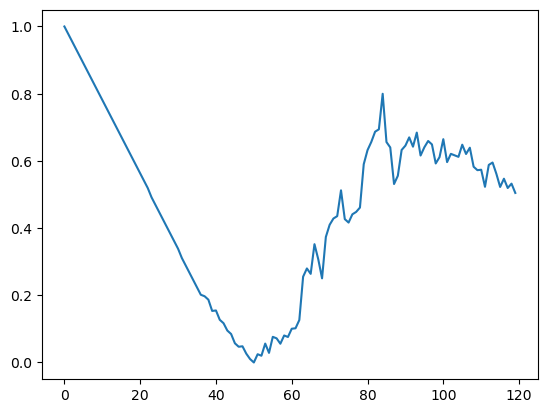

In [51]:
plt.plot(normalized)
plt.show()

In [52]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]